# CMSE 381 Final Project Template

**INSTRUCTIONS**: This is a template to help organize your project.  All projects should include the 5 major sections below (you do not need to use this template file).  If you use this file, complete your work below and remove content in parentheses. Also, remove this current cell.  

#### CMSE 381 Final Project
###  Group members: Sukaina Alkhalidy, Sherry
###  Section_001
####  The Freiwald Tsao Face View AM dataset

# Neural Decoding of Faces and Head Orientation

## Background and Motivation

_(Provide context for the problem.  **Clearly state the question(s) you set
out to answer.**)_

## Questions:

### question 1 :Can we classify the face identity seen by the subject using neuron activity?
### question 2: Can we determine the head orientation based on neural responses?
### Question 3: How accurately can different machine learning models decode facial perception?

## Methodology
_(How did you go about answering your question(s)? You should wrote some code here to demonstrate what the data is like and how in principle your method works. You can leave the variations of the related to specific results to the results section.)_

In [27]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Enable inline plotting for Jupyter Notebook
%matplotlib inline


### First, we load the dataset from the extracted folder and inspect its structure.

In [28]:

# Define the dataset folder path
folder_path = "Freiwald_Tsao_faceviews_AM_data_csv"

# List all CSV files
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Load one sample file to inspect the structure
sample_file = os.path.join(folder_path, csv_files[0])  # First CSV file
df = pd.read_csv(sample_file)

# Display info
print("Dataset Loaded:", sample_file)
print(df.head())  # Show first few rows
print(df.info())  # Column details



Dataset Loaded: Freiwald_Tsao_faceviews_AM_data_csv/raster_data_bert_am_site070.csv
  site_info.monkey site_info.region  labels.stimID  labels.person  \
0             bert               am              1              1   
1             bert               am              1              1   
2             bert               am              1              1   
3             bert               am              1              1   
4             bert               am              1              1   

  labels.orientation labels.orient_person_combo  time.1_2  time.2_3  time.3_4  \
0              front                    front 1         0         0         0   
1              front                    front 1         0         0         0   
2              front                    front 1         0         0         0   
3              front                    front 1         0         0         0   
4              front                    front 1         0         0         0   

   time.4_5  .

### Handling Missing Data
## The dataset has no explicit missing values, but we handle any potential issues.

In [29]:
df = df.replace('?', np.nan)  # Convert '?' to NaN if applicable
df = df.dropna()  # Drop rows with missing values
print("Dataset shape after cleaning:", df.shape)


Dataset shape after cleaning: (1600, 806)


In [30]:
print(df.dtypes)  # Check column data types


site_info.monkey      object
site_info.region      object
labels.stimID          int64
labels.person          int64
labels.orientation    object
                       ...  
time.796_797           int64
time.797_798           int64
time.798_799           int64
time.799_800           int64
time.800_801           int64
Length: 806, dtype: object


####  Exploratory Data Analysis (EDA) Now, let's analyze the data to understand its distribution.
### Check the Distribution of Labels (Face Identity & Orientation)

/Users/sukainaalkhalidy/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sukainaalkhalidy/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sukainaalkhalidy/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


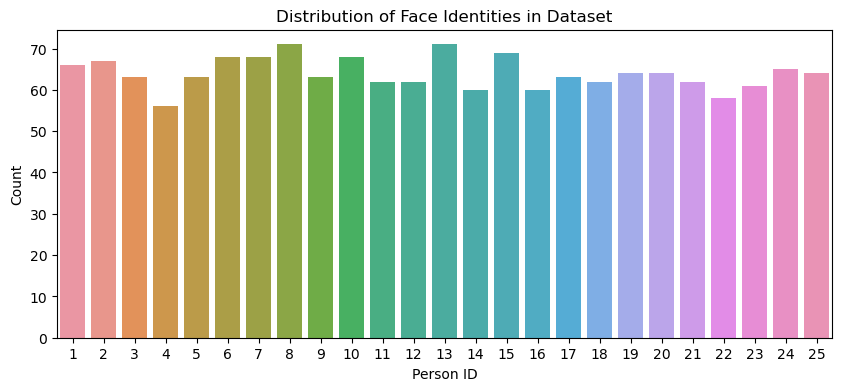

/Users/sukainaalkhalidy/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sukainaalkhalidy/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sukainaalkhalidy/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


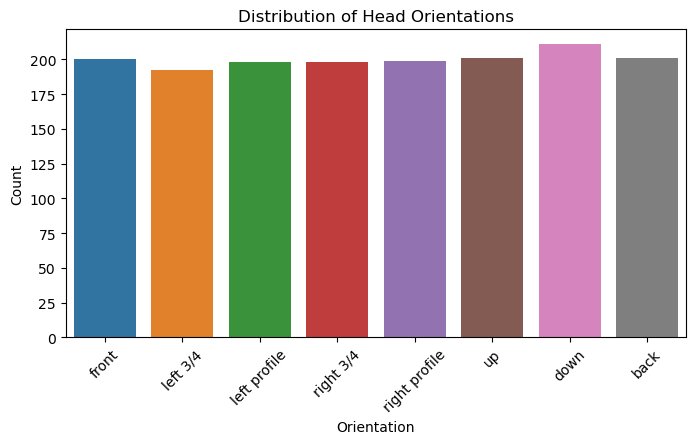

In [31]:

plt.figure(figsize=(10, 4))

# Count of different individuals in the dataset
sns.countplot(x=df["labels.person"])
plt.title("Distribution of Face Identities in Dataset")
plt.xlabel("Person ID")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8, 4))

# Count of different orientations
sns.countplot(x=df["labels.orientation"])
plt.title("Distribution of Head Orientations")
plt.xlabel("Orientation")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [32]:
df = pd.get_dummies(df, columns=['site_info.monkey', 'site_info.region', 'labels.orientation', 'labels.orient_person_combo'])

# Drop non-feature columns (target variable and any metadata not needed)
X = df.drop(columns=['labels.person', 'labels.stimID'])
y = df['labels.person']  # Target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [33]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate performance
print("Random Forest Classifier Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Classifier Accuracy: 1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00        16
           7       1.00      1.00      1.00        11
           8       1.00      1.00      1.00        14
           9       1.00      1.00      1.00        17
          10       1.00      1.00      1.00        11
          11       1.00      1.00      1.00         9
          12       1.00      1.00      1.00        12
          13       1.00      1.00      1.00        17
          14       1.00      1.00      1.00         9
          15       1.00      1.00      1.00        15
          16       1.00      1.00      1.00        15
          17       1.00      1.00      1.0

In [35]:
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# Evaluate performance
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


SVM Accuracy: 0.996875
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00        16
           7       1.00      1.00      1.00        11
           8       1.00      1.00      1.00        14
           9       1.00      1.00      1.00        17
          10       1.00      1.00      1.00        11
          11       1.00      1.00      1.00         9
          12       1.00      1.00      1.00        12
          13       1.00      1.00      1.00        17
          14       1.00      1.00      1.00         9
          15       1.00      1.00      1.00        15
          16       1.00      1.00      1.00        15
          17       1.00      1.00      1.00        12
    

### Data
_(Describe the data you are using. What variables are you using? What they mean? Why did you choose them?)_

In [14]:
# you may need some code here to adjust the format or organization of your data so that
#they can be used for the model


In [1]:
# you may want to write some code to see what the data looks like

### Models for classification _(if applicable)_
_(What models will you be using for classification? Why did you choose to use them? What questions would you answer with them? How would you evaluate if each model? What cross-validation method did you use?)_

In [ ]:
# you may add some code here to show how the model works in principle

### Models for regression _(if applicable)_
_(What models will you be using for regression? Why did you choose to use them? What questions would you answer with them? How would you evaluate if each model? What cross-validation method did you use?)_

In [ ]:
# you may add some code here to show how the model works in principle

### Other methods used _(if applicable)_

_(If this is a preprocessing step to prepare your data for regression or classification models, you should put this subsection before your explanation for the regression or classification models.)_

_(What method did you use otherwise? Why did you choose to use them? What questions would you answer with them? How would you evaluate the results? What cross-validation method did you use when applicable?)_

In [ ]:
# you may add some code here to show how the method works in principle

# you may add some code here to show how the model works in principle

## Results

_(What did you find when you carried out your methods? Some of your code related to
presenting results/figures/data may be replicated from the methods section or may only be present in
this section. All of the plots that you plan on using for your presentation should be present in this
section)_

### classification results
_(What are you trying to do here?)_

In [ ]:
# how did you do it

_(How do you interpret what you see?)_

_(What are you doing next?)_

In [ ]:
# how did you do it (etc. etc.)

### regression results
_(What are you trying to do here?)_

In [ ]:
# how did you do it

_(How do you interpret what you see?)_

_(What are you doing next?)_

In [ ]:
# how did you do it (etc. etc.)

### other results
_(What are you trying to do here?)_

In [ ]:
# how did you do it

_(How do you interpret what you see?)_

_(What are you doing next?)_

In [ ]:
# how did you do it (etc. etc.)

## Discussion and Conclusion

_(What did you learn from your results? What obstacles did you run into? What would you do differently next time? Clearly provide quantitative answers to your question(s)?  At least one of your questions should be answered with numbers.  That is, it is not sufficient to answer "yes" or "no", but rather to say something quantitative such as variable 1 increased roughly 10% for every 1 year increase in variable 2.)_

### discussion on the classification results

### discussion on the other results

### conclusion and future steps

## Author contribution

_(Please describe the contribution of each member of group)._

## References

_(List the source(s) for any data and/or literature cited in your project.  Ideally, this should be formatted using a formal citation format (MLA or APA or other, your choice!).   Multiple free online citation generators are available such as <a href="http://www.easybib.com/style">http://www.easybib.com/style</a>. **Important:** if you use **any** code that you find on the internet for your project you **must** cite it or you risk losing most/all of the points for you project.)_

### Freiwald, W. A., & Tsao, D. Y. (2010). Functional compartmentalization and viewpoint generalization within the macaque face-processing system. Science, 330(6005), 845-851.

### Meyers, E. M., Borzello, M., Freiwald, W. A., & Tsao, D. (2015). Intelligent information loss: The coding of facial identity, head pose, and non-face information in the macaque face patch system. Journal of Neuroscience, 35(18)

### “Seaborn.Countplot#.” Seaborn.Countplot - Seaborn 0.13.2 Documentation, seaborn.pydata.org/generated/seaborn.countplot.html. Accessed 5 Mar. 2025. 